In [153]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
import torch
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        
        self.pool2 = enn.PointwiseMaxPool(feat_type_out,kernel_size=15, stride=1, padding=7)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=3).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor

In [154]:
import torch
import torch.nn.functional as F
import numpy as np

class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        """
        Detects the maximum points in a batch of images.

        Args:
        - images: Tensor with dimensions [b, channel, height, width] containing the images.
        - size: Size of the maximum filter.
        - threshold: Threshold to consider a point as maximum.

        Returns:
        - max_coords_values: Tensor containing the coordinates of the maximum points along with the corresponding scalar values.
        - max_map: Tensor containing the resulting maximum map.
        """
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0,1,3,2,4]]# trocando x e y de ordem antes de concatenar

        return max_coords_values, max_map.squeeze().numpy()

    def filter_coordinates(self, tensor, image_index, channel_index):
        """
        Filters coordinates in a tensor based on the image and channel indices.

        Args:
        - tensor: Tensor with dimensions [b, channel, x, y] containing the data.
        - image_index: Image index to filter the coordinates.
        - channel_index: Channel index to filter the coordinates.

        Returns:
        - filtered_coords: Tensor containing the filtered coordinates.
        """
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords

    def sort_matrix_by_last_element(self, matrix):
        """
        Sorts the rows of a matrix based on the last element of each row.

        Args:
        - matrix: NumPy array representing the matrix.

        Returns:
        - sorted_matrix: NumPy array with sorted rows in descending order based on the last element.
        """
        indices = np.argsort(-matrix[:, -1])  # Sort based on the last column
        sorted_matrix = matrix[indices]
        return sorted_matrix
    
detector = MaxPointDetector()
NSM_SIZE = 11 # tem que ser impar

In [155]:
from config import args, device
from matplotlib import pyplot as plt

from training import KeyEqGroup
from utils import load_model,save_model

from torchvision.transforms import transforms, InterpolationMode
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

torch.manual_seed(42)
torch.cuda.manual_seed(42)
#flowers_ssim_q orient kp_loss
#flowers_ssim_t orient triplet_loss no ssim
MODEL_PATH = "./data/models/model_{}.pt".format("flowers_ssim_q")
print(MODEL_PATH)
args.img_size = 170
args.dim_first = 2
args.dim_second = 3
args.dim_third = 4
args.batch_size = 11
args.is_loss_ssim = True


transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)



model = KeyEqGroup(args).to(device)
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.75)

try:
    model, optimizer, i_epoch, loss = load_model(model, optimizer, path=MODEL_PATH)
    print("Já foi treinado")
    print("epoca {} loss {}".format(i_epoch, loss))
except:
    print("Não foi treinado ainda")




./data/models/model_flowers_ssim_q.pt
Já foi treinado
epoca 10 loss 1.7278551400876518


In [156]:

iterator=iter(trainloader)
batch = next(iterator)
img_batch, labels =batch
img_batch = img_batch.to(device)[:1]
print(img_batch.shape)


torch.Size([1, 3, 170, 170])


In [157]:
import matplotlib.pyplot as plt

#function plot imagem and coords
def plot_image_and_coords(image, coords):
    plt.imshow(image)
    for i, (x,y) in enumerate(coords):
        plt.plot(x, y, '.',markerfacecolor='none', markeredgecolor='r',
                markersize=10, markeredgewidth=1)
        plt.annotate(str(i), (x, y), color='r',xytext=(3, 3), textcoords='offset points', fontsize=12)
    plt.show()
    

def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

def criar_mascara(dimensao_janela, tamanho_borda):

    mascara = torch.zeros((1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)


def detector_sumary(batch,nsm_size=11,threshold=1e-3,mask=None):
    detector = MaxPointDetector()
    max_coords_values, max_map = detector.detect_max_points(batch, size=nsm_size, threshold=threshold)
    valores_filtrados = detector.filter_coordinates(max_coords_values, image_index=0, channel_index=0)
    if mask is not None:
        # Check valid points
        valores_filtrados = check_valid_points(valores_filtrados.unsqueeze(0), mask)

    valores_ordenados = detector.sort_matrix_by_last_element(valores_filtrados)
    points = valores_ordenados[:50, 0:2][None]
    print('pontos detectados do batch ',max_coords_values.shape,' pontos de uma imagem',points.shape,max_map.shape)
    return points,max_map

def predict(model, batch):
    model.eval()
    with torch.no_grad():
        feat,oriet = model(batch)
        print(batch.shape,feat.shape,oriet.device)
    return feat,oriet

In [158]:
#Ultilizar uma rede mais simples
# model = Feature(n_channel=3)
# model = model.to(img_batch.device)

170 torch.Size([1, 170, 170])
torch.Size([1, 3, 170, 170]) torch.Size([1, 1, 170, 170]) cuda:0
pontos detectados do batch  torch.Size([80, 5])  pontos de uma imagem torch.Size([1, 50, 2]) (170, 170)


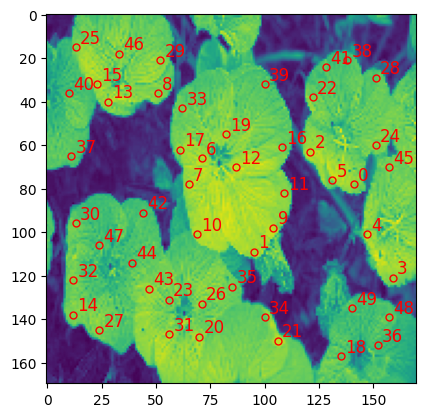

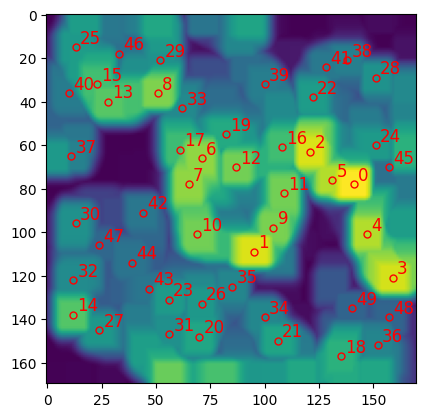

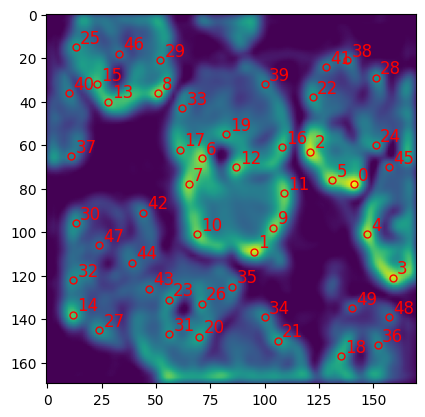

In [159]:
from predict import compute_gradient_direction

dimensao_janela = img_batch.shape[-1]
mask = criar_mascara(dimensao_janela, NSM_SIZE//2)
print(dimensao_janela,mask.shape)

feat,oriet = predict(model,img_batch)
output_batch = feat.cpu().detach()
orie_img_batch = compute_gradient_direction(oriet).to(output_batch.device)
points,max_map = detector_sumary(output_batch,nsm_size=NSM_SIZE,mask=mask[0])


plot_image_and_coords(img_batch[0,0].cpu().detach(), points[0])
plot_image_and_coords(max_map, points[0])
plot_image_and_coords(output_batch[0,0], points[0])

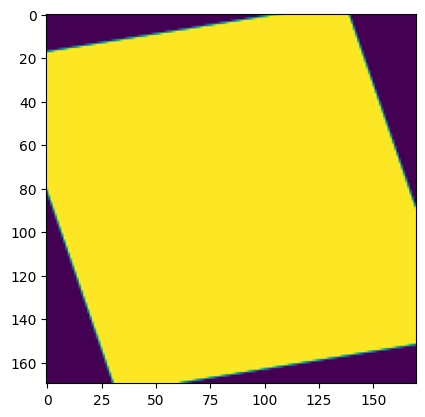

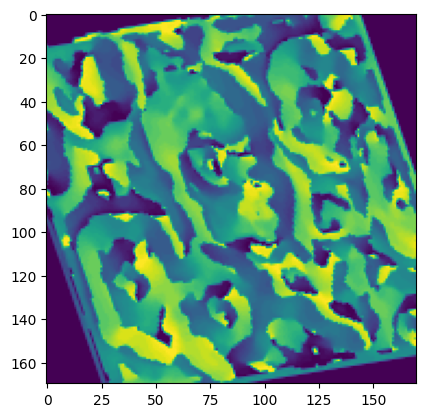

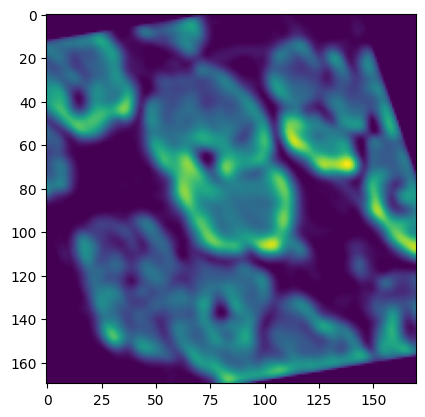

In [160]:
import kornia
import kornia.augmentation as K


aug_list = K.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=[-45, 45],shear=10,align_corners=False, p=1.,same_on_batch=True,keepdim=True),
    data_keys=["input","input","input","input","input","keypoints"]
)


_max_map= torch.tensor(max_map,dtype=torch.float32)


input_trans,_max_map_trans,mask_trans,output_batch_trans,orie_max_trans,points_trans = aug_list(img_batch,_max_map,mask,output_batch,orie_img_batch, points)

plt.imshow(mask_trans[0].cpu())
plt.show()
plt.imshow(orie_max_trans[0,0].cpu())
plt.show()
plt.imshow(output_batch_trans[0,0].cpu())

torch.Size([1, 3, 170, 170]) torch.Size([1, 1, 170, 170]) cuda:0
Diferença entre os mapas de ativação t(f(x)) - f(t(x))
tensor(0.) tensor(9.8736) tensor(0.) tensor(10.1936) tensor(0.) tensor(4.9987)


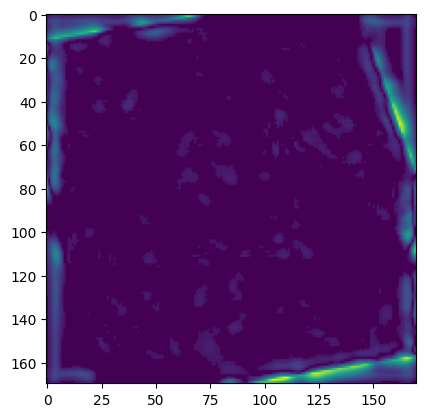

Diferença entre os mapas de orientacao t(o(x)) - o(t(x))
tensor(0.) tensor(350.) tensor(0.) tensor(350.0000)


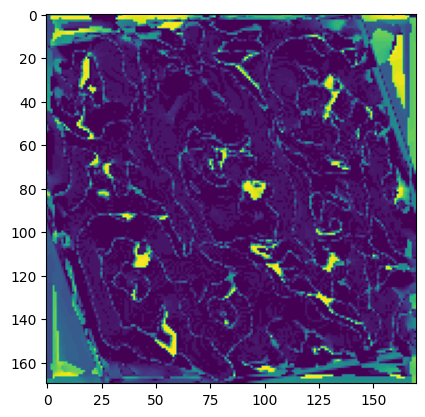

pontos detectados do batch  torch.Size([73, 5])  pontos de uma imagem torch.Size([1, 50, 2]) (170, 170)
t(f(x)) - Mapa de ativação transformado


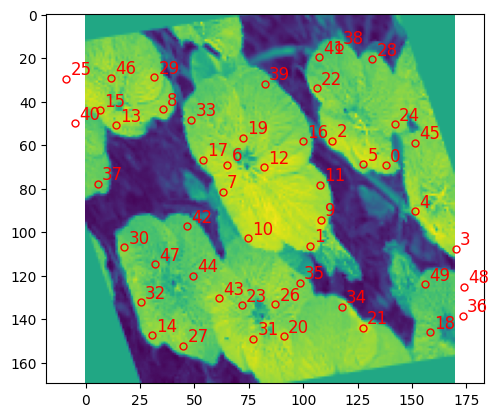

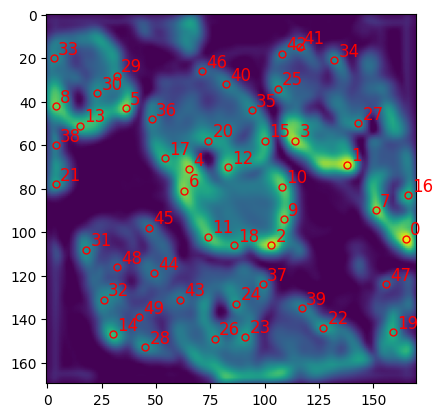

t(f(x)) - NSM original transformado


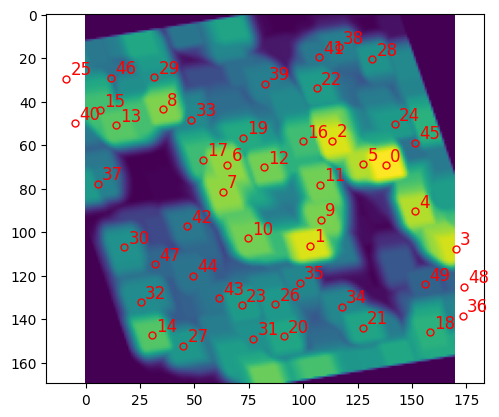

f(t(x)) - NSM novo


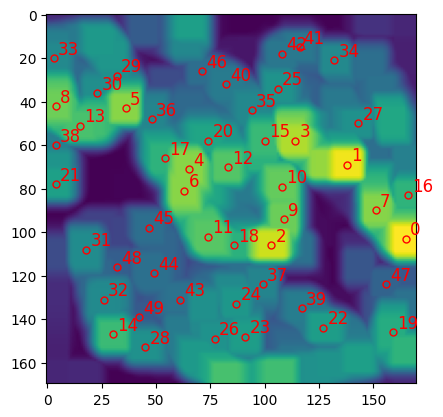

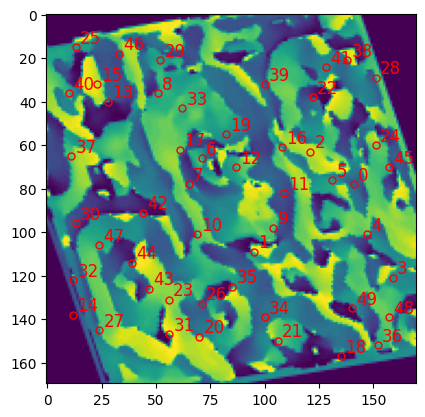

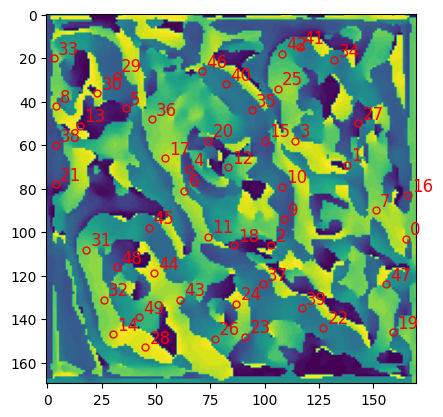

In [161]:
gauss = kornia.filters.GaussianBlur2d((5, 5), (1.5, 1.5))

feat2,oriet2 = predict(model,input_trans)
output_batch2 = feat2.cpu().detach()
orie_max2 = compute_gradient_direction(oriet2).to(output_batch2.device)


print("Diferença entre os mapas de ativação t(f(x)) - f(t(x))")
diff_out = abs(output_batch2-output_batch_trans)
print(output_batch.min(),output_batch.max(),output_batch2.min(),output_batch2.max(),diff_out.min(),diff_out.max())
diff_out = diff_out/diff_out.max()
diff_out[diff_out<0.05]=0


plt.imshow(diff_out[0,0].cpu(),vmin=0,vmax=1)
plt.show()


print("Diferença entre os mapas de orientacao t(o(x)) - o(t(x))")

# orie_max_trans=gauss(orie_max_trans)
# orie_max2=gauss(orie_max2)

diff_out2 = abs(orie_max2-orie_max_trans)
print(orie_max2.min(),orie_max2.max(),diff_out2.min(),diff_out2.max())
diff_out2 = diff_out2/diff_out2.max()
diff_out2[diff_out2<0.05]=0


plt.imshow(diff_out2[0,0].cpu(),vmin=0,vmax=1)
plt.show()

points2,max_map2 = detector_sumary(output_batch2,nsm_size=NSM_SIZE,mask=mask_trans[0])

print("t(f(x)) - Mapa de ativação transformado")
plot_image_and_coords(input_trans[0,0].cpu().detach(), points_trans[0])
plot_image_and_coords(output_batch2[0,0], points2[0])
print("t(f(x)) - NSM original transformado")
plot_image_and_coords(_max_map_trans, points_trans[0])
print("f(t(x)) - NSM novo")
plot_image_and_coords(max_map2, points2[0])

plot_image_and_coords(orie_max_trans[0,0].cpu().detach(), points[0])

plot_image_and_coords(orie_max2[0,0].cpu().detach(), points2[0])



f(x) , onde x a imagem, f a funcao dos pontos e t a transformada


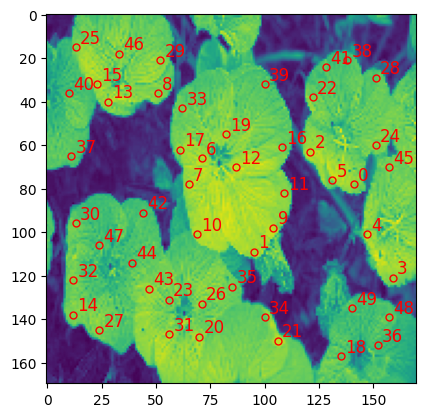

t(f(x))


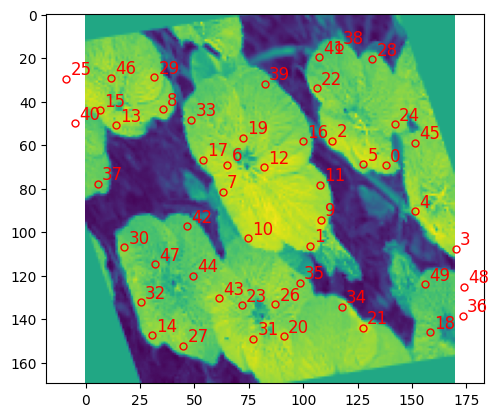

f(t(x))


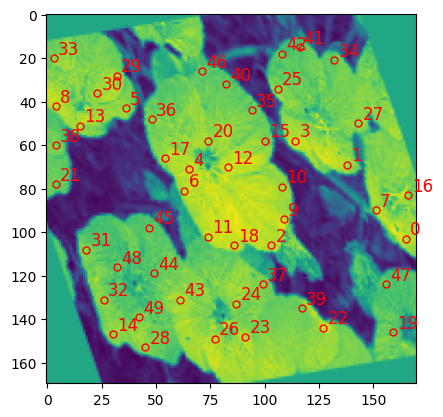

In [162]:
print("f(x) , onde x a imagem, f a funcao dos pontos e t a transformada")
plot_image_and_coords(img_batch[0,0].cpu().detach(), points[0])
print("t(f(x))")
plot_image_and_coords(input_trans[0,0].cpu().detach(), points_trans[0])
print("f(t(x))")
plot_image_and_coords(input_trans[0,0].cpu().detach(), points2[0])

torch.Size([1, 1, 170, 170]) torch.Size([1, 1, 170, 170])
tensor(0.) tensor(350.)
<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[7782.5591]])
interval : 0  -  60


C:\Users\renga\AppData\Local\Temp\ipykernel_6200\814208861.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interval_mask  = intersection_filter_interval_mask(interval_mask,torch.tensor(mask[None]))


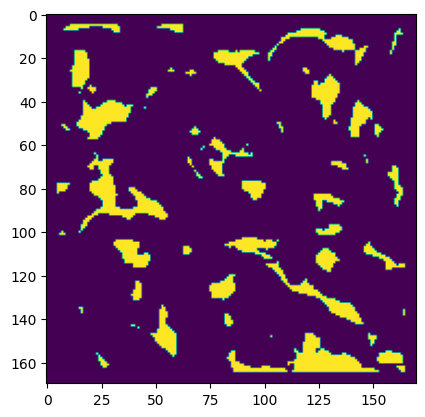

<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[10286.3184]])
interval : 60  -  120


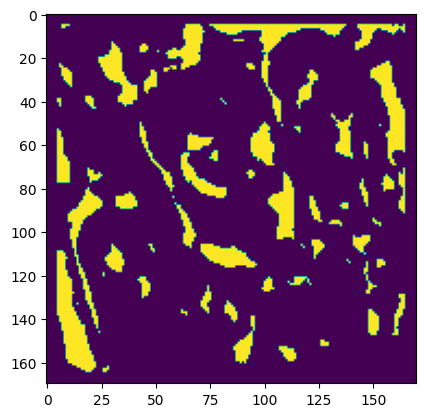

<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[13606.2803]])
interval : 120  -  180


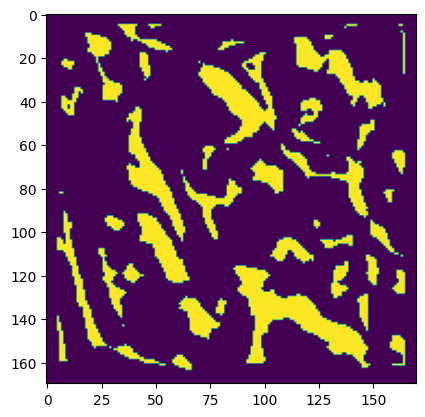

<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[7192.4868]])
interval : 180  -  240


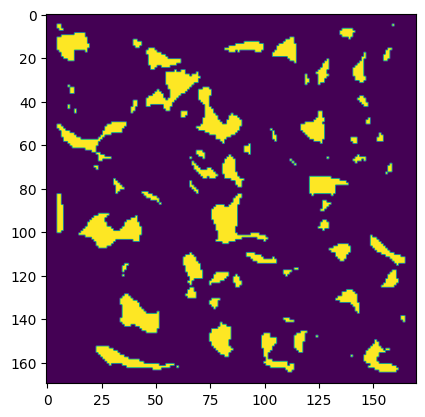

<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[12816.5000]])
interval : 240  -  300


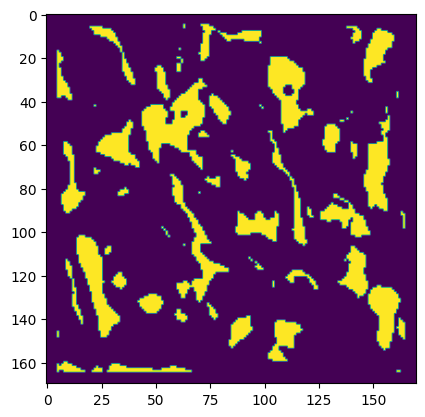

<class 'torch.Tensor'> torch.Size([1, 170, 170])
sum_b  torch.Size([1, 1]) tensor([[13047.7002]])
interval : 300  -  360


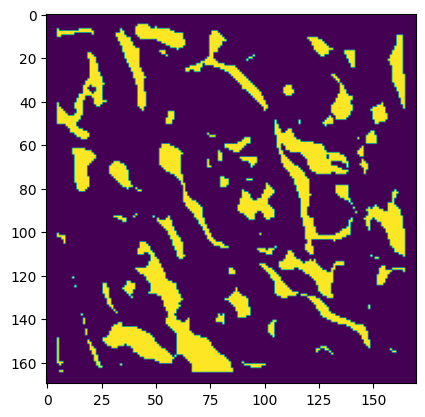

tensor([[0.5720, 0.7560, 1.0000, 0.5286, 0.9420, 0.9589]])

In [163]:
from utils import sum_filtered_intensity,build_histogram_orientation,create_interval_mask,intersection_filter_interval_mask

def normalize_vector(tensor):
    max_value = torch.max(tensor)
    normalized_tensor = tensor / max_value
    return normalized_tensor

def sum_filtered_intensity(batch,filter):
    batch_filtered = batch * filter
    sum_batch = torch.sum(batch_filtered,dim=(2,3))
    return sum_batch,batch_filtered


def build_histogram_orientation(ori_arg_max,_kp1,mask,n_bin,show=False):
    #cria mascara para remocao de borda
    print(ori_arg_max.min(),ori_arg_max.max())
    hist_batch =None
    for i in range(n_bin):
        v_bin = 360//n_bin
        int_0 = v_bin*i
        int_1 = v_bin*(i+1)
        interval_mask = create_interval_mask(ori_arg_max,int_0,int_1)
        if mask is not None:
            interval_mask  = intersection_filter_interval_mask(interval_mask,torch.tensor(mask[None]))
            print(type(mask),mask.shape)

        sum_b, batch_filtered = sum_filtered_intensity(_kp1,interval_mask)
        print('sum_b ',sum_b.shape,sum_b)
        print('interval :',int_0," - ",int_1)
        if show:
            plt.imshow(interval_mask[0,0].cpu().detach())
            plt.show()
        if hist_batch is None:
            hist_batch = sum_b
        else:
            hist_batch=torch.cat((hist_batch,sum_b),1)
    return  normalize_vector(hist_batch)

num_bin = 6
print(orie_max2.shape,feat2.shape)
hist2_b = build_histogram_orientation(orie_max2.cpu(),feat2.cpu(),mask,num_bin,show=True)
hist2_b